# Version 1.0

## Data Sources

**OpenWeatherMap**: Smooth data and accurate compared to Google Weather data 

**Open-Mateo**: Very quick to download and free, also provides ensemble forecasting for day ahead timeframe

    Note: Convention to put the target column in the first column (index = 0)

## Regression
**Still to be hyperparamater tuned, to serve as baseline for future models**

- Random Forests
- kNN 
- xGBoost 
- Ridge 

**Notes:**
- Very lightweight models and trains fast on Laptop resources, able to track the seasonality of the wind speed.
- Easily able to incorporate uni-variate and multi-variate structures where the multi-variate forecasting is slightly more acurate.

- Rollout does not work as well as having multiple outputs

**Preliminary results**
- The OWM data was proved more suitable for the models to adjust and learn

**To-do**

- Tune hyperparameters
- Play with the windowsize

## Deep-Learning

**PyTorch vs TensorFlow**

[Read the differences ](https://www.turing.com/kb/pytorch-vs-tensorflow)

**Still to be designed and tested**
- NN
- CNN
- RNN
- LSTM
- GNN
- LGBM

_Examples at:_

[Set Scholars](https://setscholars.net/)





# Imports

In [48]:
from shared_utilities import *

# Utilities

In [49]:
def setup_data(data_ = f'data\Sere Wind Farm_hourly_OWM.csv', train_ = False, uni = True, window_size = 24*4, step = 24, sanity_check = False, tensor_ = False):
    if uni:
        column_ = 0
    else:
        column_ = None

    dm = WeatherDataModule(data_dir=data_, 
                        window_size=window_size, column=column_,
                        batch_size=32, step_=step, 
                        normalize_=True, return_tensor=tensor_)

    dm.prepare_data()
    dm.setup('')

    if sanity_check:
        plt.plot(np.arange(window_size),dm.f_test[0], label='Input')
        if step == 1:
            plt.scatter(np.arange(window_size, window_size+step),dm.t_test[0], label='Target', s=5, c='r')
        else:
            plt.plot(np.arange(window_size, window_size+step),dm.t_test[0], label='Target', c='r')
        plt.legend()
        plt.show()

    return dm

def plot_models(models, model_names, colors, X, y, height, width, interval, window_size, step):
    mse_tracker = []

    fig, axes = plt.subplots(height,width, figsize=(18, 3 * height))

    for i, ax_row in enumerate(axes):
            for j, ax in enumerate(ax_row):
                seed_index = i * 2 + j
                seed = seed_index * interval 

                current_data = X[seed]
                true_data = y[seed]

                average = np.zeros(step)

                ax.plot(np.arange(window_size), current_data, label='Input')
                ax.plot(np.arange(window_size, window_size+step), true_data, label='Target', c='blue')

                for model in models:
                    try:
                        pred = model.predict(current_data.reshape(1,-1), verbose = 0).squeeze()
                    except:
                        pred = model.predict(current_data.reshape(1,-1)).squeeze()
                    ax.plot(np.arange(window_size, window_size+step), pred, label=model_names[models.index(model)], c=colors[models.index(model)])
                    average += pred

                average /= len(models)

                ax.plot(np.arange(window_size, window_size+step), average, label='Average', c='black', linestyle='--')
                
                if i == 0 and j == 0:  
                    ax.legend(loc='upper left')

                ax.set_title(f"Seed: {seed}")


    plt.tight_layout()
    plt.show()

def metrics(models, model_names, X, y, window_size, step):
    mse = []
    for model in models:
        try:
            pred = model.predict(X, verbose=0)
        except:
            pred = model.predict(X)
        mse.append(mean_squared_error(y, pred))
        print(f"MSE for {model_names[models.index(model)]} model: {mse[-1]}")

    plt.figure(figsize=(8, 6))  
    plt.bar(model_names, mse)
    plt.xlabel('Models')
    plt.ylabel('Normalized Mean Squared Error (MSE)')
    plt.title('MSE for Different Models')
    plt.show()


# Setup

In [56]:
window_size = 24*6
step = 38
source = 'ERA'
load_folder = 'models_compare'

# dm = setup_data(data_=f'data\Sere Wind Farm_hourly_{source}.csv', train_ = False, uni = True, window_size = window_size, step = step, sanity_check = False, tensor_=False)

dm = setup_data(data_=f'ERA5_Data\ERA5_Reanalysis.csv', train_ = False, uni = True, window_size = window_size, step = step, sanity_check = False, tensor_=False)

rfr_model, xgb_model, knn_model, ridge_model = load_models(dm = dm, folder=load_folder, window_size=window_size, step=step)

model_dnn= tf.keras.models.load_model(f"{load_folder}/keras_model_DNN_ws_{window_size}_{step}_{source}.h5")
model_lstm= tf.keras.models.load_model(f"{load_folder}/keras_model_LSTM_ws_{window_size}_{step}_{source}.h5")
model_gru= tf.keras.models.load_model(f"{load_folder}/keras_model_GRU_ws_{window_size}_{step}_{source}.h5")
model_cnn= tf.keras.models.load_model(f"{load_folder}/keras_model_CNN_ws_{window_size}_{step}_{source}.h5")
# model_test = tf.keras.models.load_model(f"{load_folder}/keras_model_test_ws_{window_size}_{step}_{source}.h5")

Train: (6132, 144)
Valid: (1752, 144)
Test: (694, 144)


c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [19:41:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


Models loaded...


# Inspect

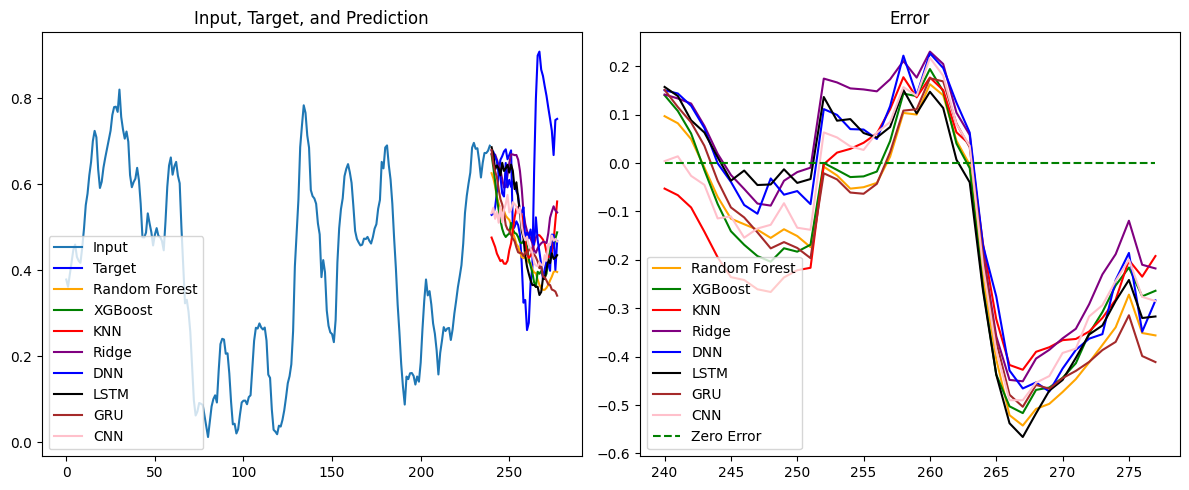

In [51]:
seed = 10

X = dm.f_valid[seed]
y = dm.t_valid[seed]

models = [rfr_model, xgb_model, knn_model, ridge_model, model_dnn, model_lstm, model_gru, model_cnn]
model_names = ['Random Forest', 'XGBoost', 'KNN', 'Ridge', 'DNN', 'LSTM', 'GRU', 'CNN']
colors = ['orange', 'green', 'red', 'purple', 'blue', 'black', 'brown', 'pink']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(np.arange(window_size), X, label='Input')
ax1.plot(np.arange(window_size, window_size+step), y, label='Target', c='blue')


for model in models:
    try:
        pred = model.predict(X.reshape(1, -1), verbose=0).squeeze()
    except:
        pred = model.predict(X.reshape(1, -1)).squeeze()
    ax1.plot(np.arange(window_size, window_size+step), pred, label=model_names[models.index(model)], c=colors[models.index(model)])
    errors = pred - y
    ax2.plot(np.arange(window_size, window_size+step), errors, label= model_names[models.index(model)], c=colors[models.index(model)])

ax1.legend()

ax2.plot(np.arange(window_size, window_size+step), np.zeros(step), label='Zero Error', c='green', linestyle='--')
ax2.legend()

ax1.set_title('Input, Target, and Prediction')
ax2.set_title('Error')

plt.tight_layout()  
plt.show()

MSE for RFR model: 0.022375688786980704
MSE for XGB model: 0.020297818791620133
MSE for KNN model: 0.03040519603804747
MSE for Ridge model: 0.01868512602678543
MSE for DNN model: 0.02077663462134117
MSE for LSTM model: 0.01956164772314549
MSE for GRU model: 0.01782261559283713
MSE for CNN model: 0.018331928808674663


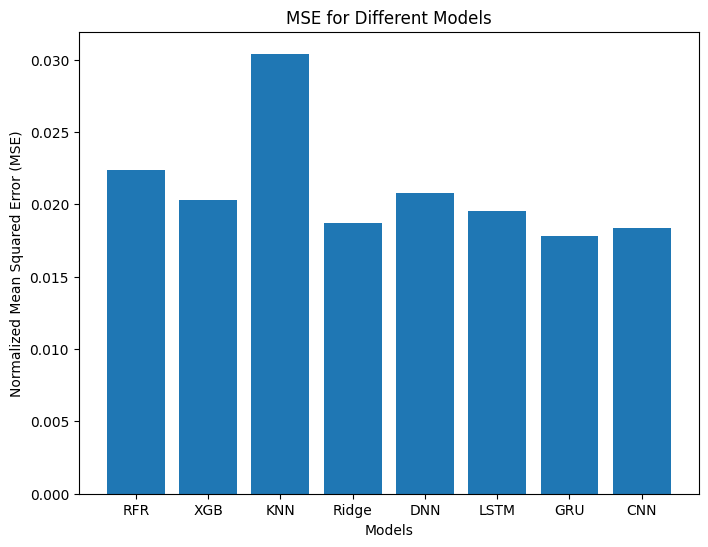

In [57]:
models = [rfr_model, xgb_model, knn_model, ridge_model, model_dnn, model_lstm, model_gru, model_cnn] #, model_test]
model_names = ['RFR', 'XGB', 'KNN', 'Ridge', 'DNN', 'LSTM', 'GRU', 'CNN'] #, 'test']
colors = ['green', 'red', 'violet', 'yellow', 'teal', 'blue', 'orange', 'brown'] #, 'pink']

metrics(models, model_names, dm.f_test, dm.t_test, window_size, step)


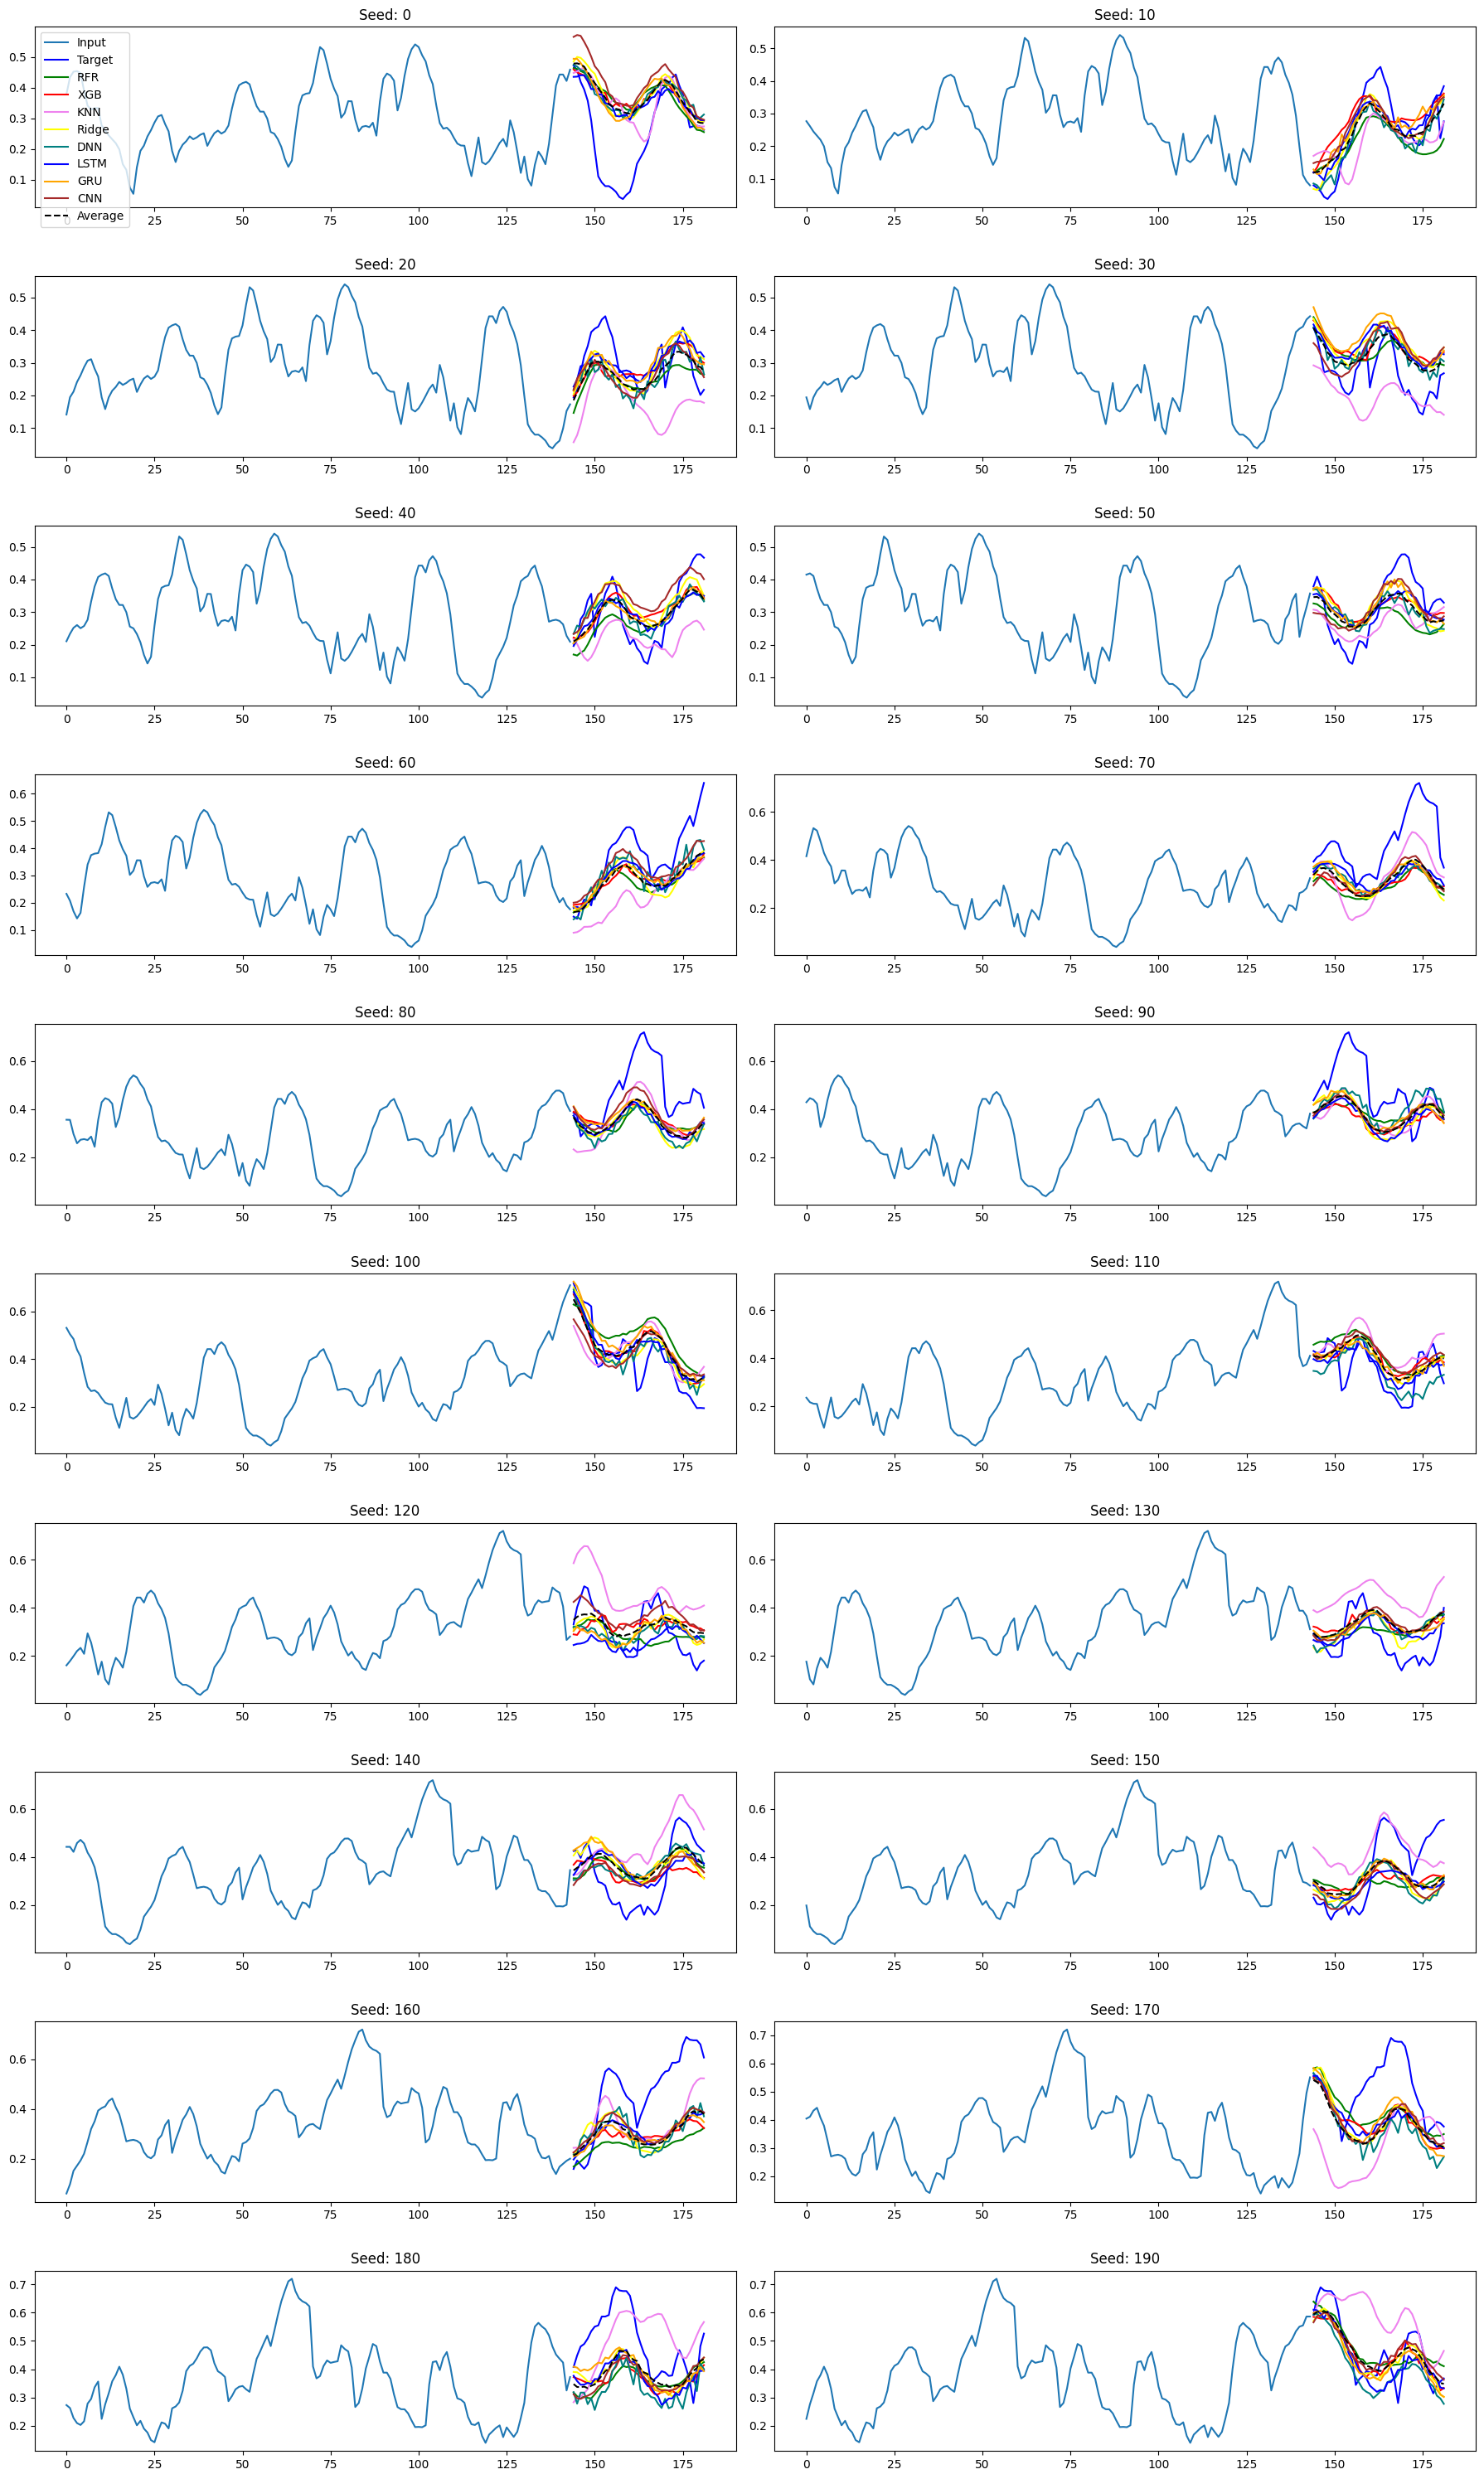

In [58]:
plot_models(models, model_names, colors, dm.f_test, dm.t_test, height=10, width=2, interval=10, window_size=window_size, step=step)

# OpenMeteo forecasts

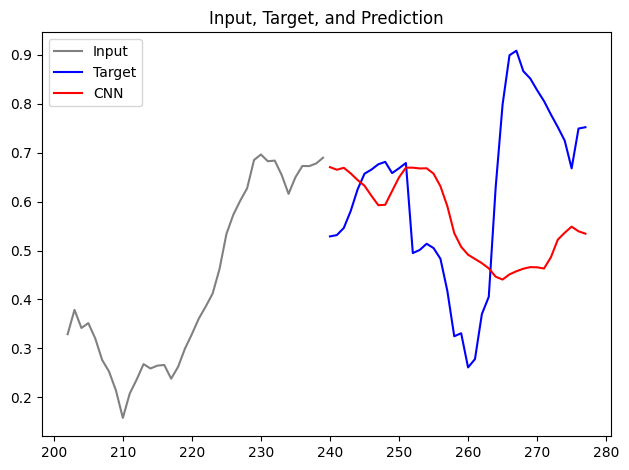

In [54]:
seed = 10

X = dm.f_valid[seed]
y = dm.t_valid[seed]

models = [rfr_model, xgb_model, knn_model, ridge_model, model_dnn, model_lstm, model_gru, model_cnn]
model_names = ['Random Forest', 'XGBoost', 'KNN', 'Ridge', 'DNN', 'LSTM', 'GRU', 'CNN']
colors = ['orange', 'green', 'pink', 'purple', 'blue', 'black', 'brown', 'red']

plt.plot(np.arange(window_size - step, window_size), X[window_size - step: window_size], label='Input', c='gray')
plt.plot(np.arange(window_size, window_size+step), y, label='Target', c='blue')

mse_prev = 100
best_pred = None

for model in models:
    try:
        pred = model.predict(X.reshape(1, -1), verbose=0).squeeze()
    except:
        pred = model.predict(X.reshape(1, -1)).squeeze()
    mse = mean_squared_error(y, pred)
    if mse < mse_prev:
        best_pred = pred
        mse_prev = mse
    

plt.plot(np.arange(window_size, window_size+step), best_pred, label=model_names[models.index(model)], c=colors[models.index(model)])

plt.legend()


plt.title('Input, Target, and Prediction')

plt.tight_layout()  
plt.show()

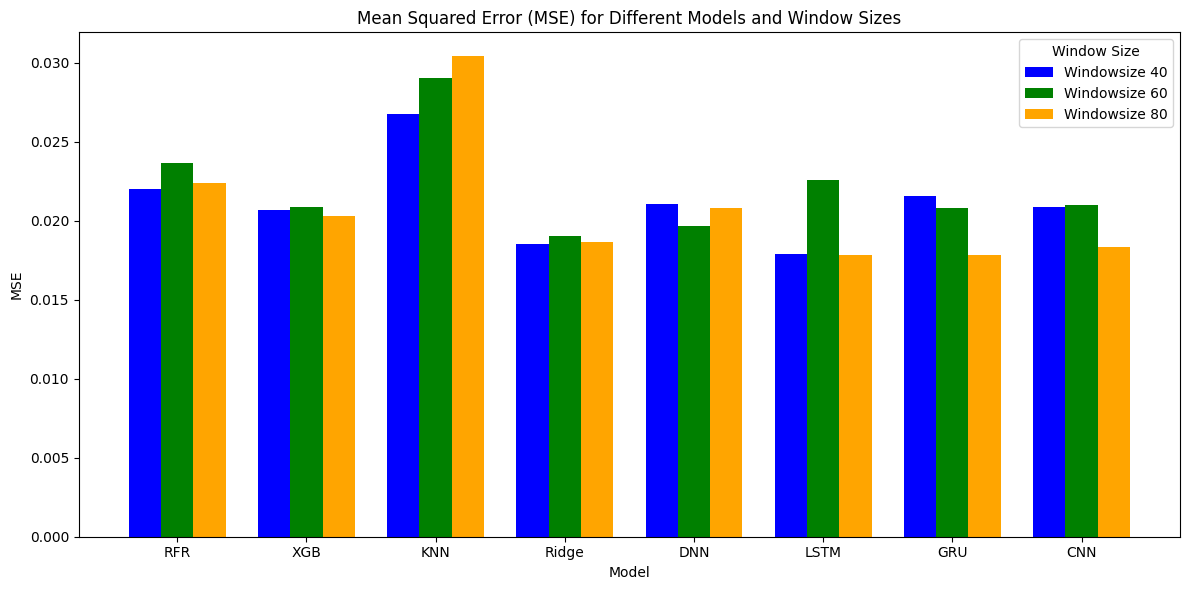

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the data for different window sizes
data = {
    'Model': ['RFR', 'XGB', 'KNN', 'Ridge', 'DNN', 'LSTM', 'GRU', 'CNN'],
    'Windowsize 40': [0.022006812165907923, 0.020670354186015722, 0.02673458660393061,
                      0.01851021040791892, 0.021044697463352965, 0.01791931284360582,
                      0.02158462949025909, 0.020868714343245304],
    'Windowsize 60': [0.02362639633127723, 0.02085831178051496, 0.02902835006423168,
                      0.01903356662473385, 0.019637286472741117, 0.02255311831894508,
                      0.020777082271450992, 0.020966795432568658],
    'Windowsize 80': [0.022375688786980704, 0.020297818791620133, 0.03040519603804747,
                      0.01868512602678543, 0.02077663462134117, 0.017839385192843768,
                      0.01782261559283713, 0.018331928808674663]
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Set the figure size
plt.figure(figsize=(12, 6))

# Define colors for each window size
colors = {'Windowsize 40': 'blue', 'Windowsize 60': 'green', 'Windowsize 80': 'orange'}

# Plotting the bar chart for each model and window size
bar_width = 0.25  # Width of each bar
models = df['Model']
x = range(len(models))

for i, ws in enumerate(['Windowsize 40', 'Windowsize 60', 'Windowsize 80']):
    plt.bar(
        [pos + i * bar_width for pos in x],
        df[ws],
        width=bar_width,
        color=colors[ws],
        label=ws
    )

# Set labels and title
plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Mean Squared Error (MSE) for Different Models and Window Sizes')
plt.xticks([pos + bar_width for pos in x], models)
plt.legend(title='Window Size')

# Show plot
plt.tight_layout()
plt.show()
